In [202]:
from datetime import datetime

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import holidays
from sklearn.linear_model import RidgeCV

%matplotlib inline
# %config InlineBackend.figure_format = "retina"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

sns.set(rc={"figure.figsize" : (20, 10)})
sns.set_style("ticks")

/var/folders/5r/_46vtm3167l75wv16plwtdq00000gq/T/ipykernel_56676/1336043820.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


In [184]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release",
         "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["post_month"]
del df["day"]
del df["month"]
df

,year,days_since_previous_release,release_post,date
id,,,,
50,2016,NaN,False,2016-02-15
123,2016,NaN,False,2016-02-15
173,2016,NaN,False,2016-02-15
156,2016,NaN,False,2016-02-15
133,2016,NaN,False,2016-02-15
...,...,...,...,...
377,2022,1.0,True,2022-07-15
378,2022,5.0,True,2022-01-25
379,2022,5.0,True,2022-09-08


In [185]:
df.query("release_post == True & days_since_previous_release.isnull()")

,year,days_since_previous_release,release_post,date
id,,,,


In [186]:
df = df[df["days_since_previous_release"].notnull()].copy()

In [187]:
df = df[df["release_post"] == True].copy()

In [188]:
df = df[df["days_since_previous_release"] != 0].copy()

In [189]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})
del df["year"]

In [190]:
df = df.sort_values(by=["date"]).set_index("date")
daily = pandas.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(daily, method=None)
df["release_post"] = df["release_post"].fillna(False)

In [191]:
df = df.reset_index()
release_dates = list(df[df["release_post"] == True]["index"])
df["closest_release_date"] = df["index"].apply(lambda x : max([d for d in release_dates if d <= x]))
df["backfill"] = (df["index"] - df["closest_release_date"]).astype("timedelta64[D]")
df["days_since_previous_release"] = df["days_since_previous_release"].fillna(df["backfill"])
del df["backfill"]
del df["closest_release_date"]
df["future_release_date"] = df["index"].apply(lambda x : min([d for d in release_dates if d >= x]))
df["days_until_next_release"] = (df["future_release_date"] - df["index"]).astype("timedelta64[D]")
del df["future_release_date"]
df

,index,days_since_previous_release,release_post,days_until_next_release
0,2017-02-26,9.0,True,0.0
1,2017-02-27,1.0,False,19.0
2,2017-02-28,2.0,False,18.0
3,2017-03-01,3.0,False,17.0
4,2017-03-02,4.0,False,16.0
...,...,...,...,...
2129,2022-12-26,5.0,False,4.0
2130,2022-12-27,6.0,False,3.0
2131,2022-12-28,7.0,False,2.0
2132,2022-12-29,8.0,False,1.0


In [192]:
df["prob_of_release"] = (df["days_since_previous_release"] /
                         (df["days_since_previous_release"] + df["days_until_next_release"]))
del df["days_until_next_release"]
del df["release_post"]

In [193]:
df["month_holidays"] = df["index"].apply(
    lambda x : len([h for h in nj_holidays if h.month == x.month and h.year == x.year]))

In [194]:
df["weekday"] = df["index"].apply(lambda x : x.strftime("%A"))
df["month"] = df["index"].apply(lambda x : x.strftime("%b"))

In [195]:
df = pandas.get_dummies(df, columns=["weekday"], prefix="WD")
df = pandas.get_dummies(df, columns=["month"], prefix="M")
df

,index,days_since_previous_release,prob_of_release,month_holidays,WD_Friday,WD_Monday,WD_Saturday,WD_Sunday,WD_Thursday,WD_Tuesday,...,M_Dec,M_Feb,M_Jan,M_Jul,M_Jun,M_Mar,M_May,M_Nov,M_Oct,M_Sep
0,2017-02-26,9.0,1.000000,4,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2017-02-27,1.0,0.050000,4,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2017-02-28,2.0,0.100000,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,2017-03-01,3.0,0.150000,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2017-03-02,4.0,0.200000,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129,2022-12-26,5.0,0.555556,2,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2130,2022-12-27,6.0,0.666667,2,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2131,2022-12-28,7.0,0.777778,2,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2132,2022-12-29,8.0,0.888889,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


---

---

In [196]:
train_df = df[0:int(len(df) * 0.85)].copy()
test_df = df[~df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

1813 321


In [201]:
features = [c for c in df.columns if c not in ["index", "prob_of_release"]]
features

['days_since_previous_release',
 'month_holidays',
 'WD_Friday',
 'WD_Monday',
 'WD_Saturday',
 'WD_Sunday',
 'WD_Thursday',
 'WD_Tuesday',
 'WD_Wednesday',
 'M_Apr',
 'M_Aug',
 'M_Dec',
 'M_Feb',
 'M_Jan',
 'M_Jul',
 'M_Jun',
 'M_Mar',
 'M_May',
 'M_Nov',
 'M_Oct',
 'M_Sep']

In [216]:
reg = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
              scoring="neg_mean_absolute_percentage_error",
              cv=3)
reg.fit(train_df[features], train_df["prob_of_release"])

RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=3,
        scoring='neg_mean_absolute_percentage_error')

In [217]:
reg.best_score_

-0.4812160934273986

In [218]:
test_df["predicted"] = reg.predict(test_df[features])

In [219]:
mape(test_df["prob_of_release"], test_df["predicted"])

0.39293205258090297

<AxesSubplot: xlabel='predicted', ylabel='residuals'>

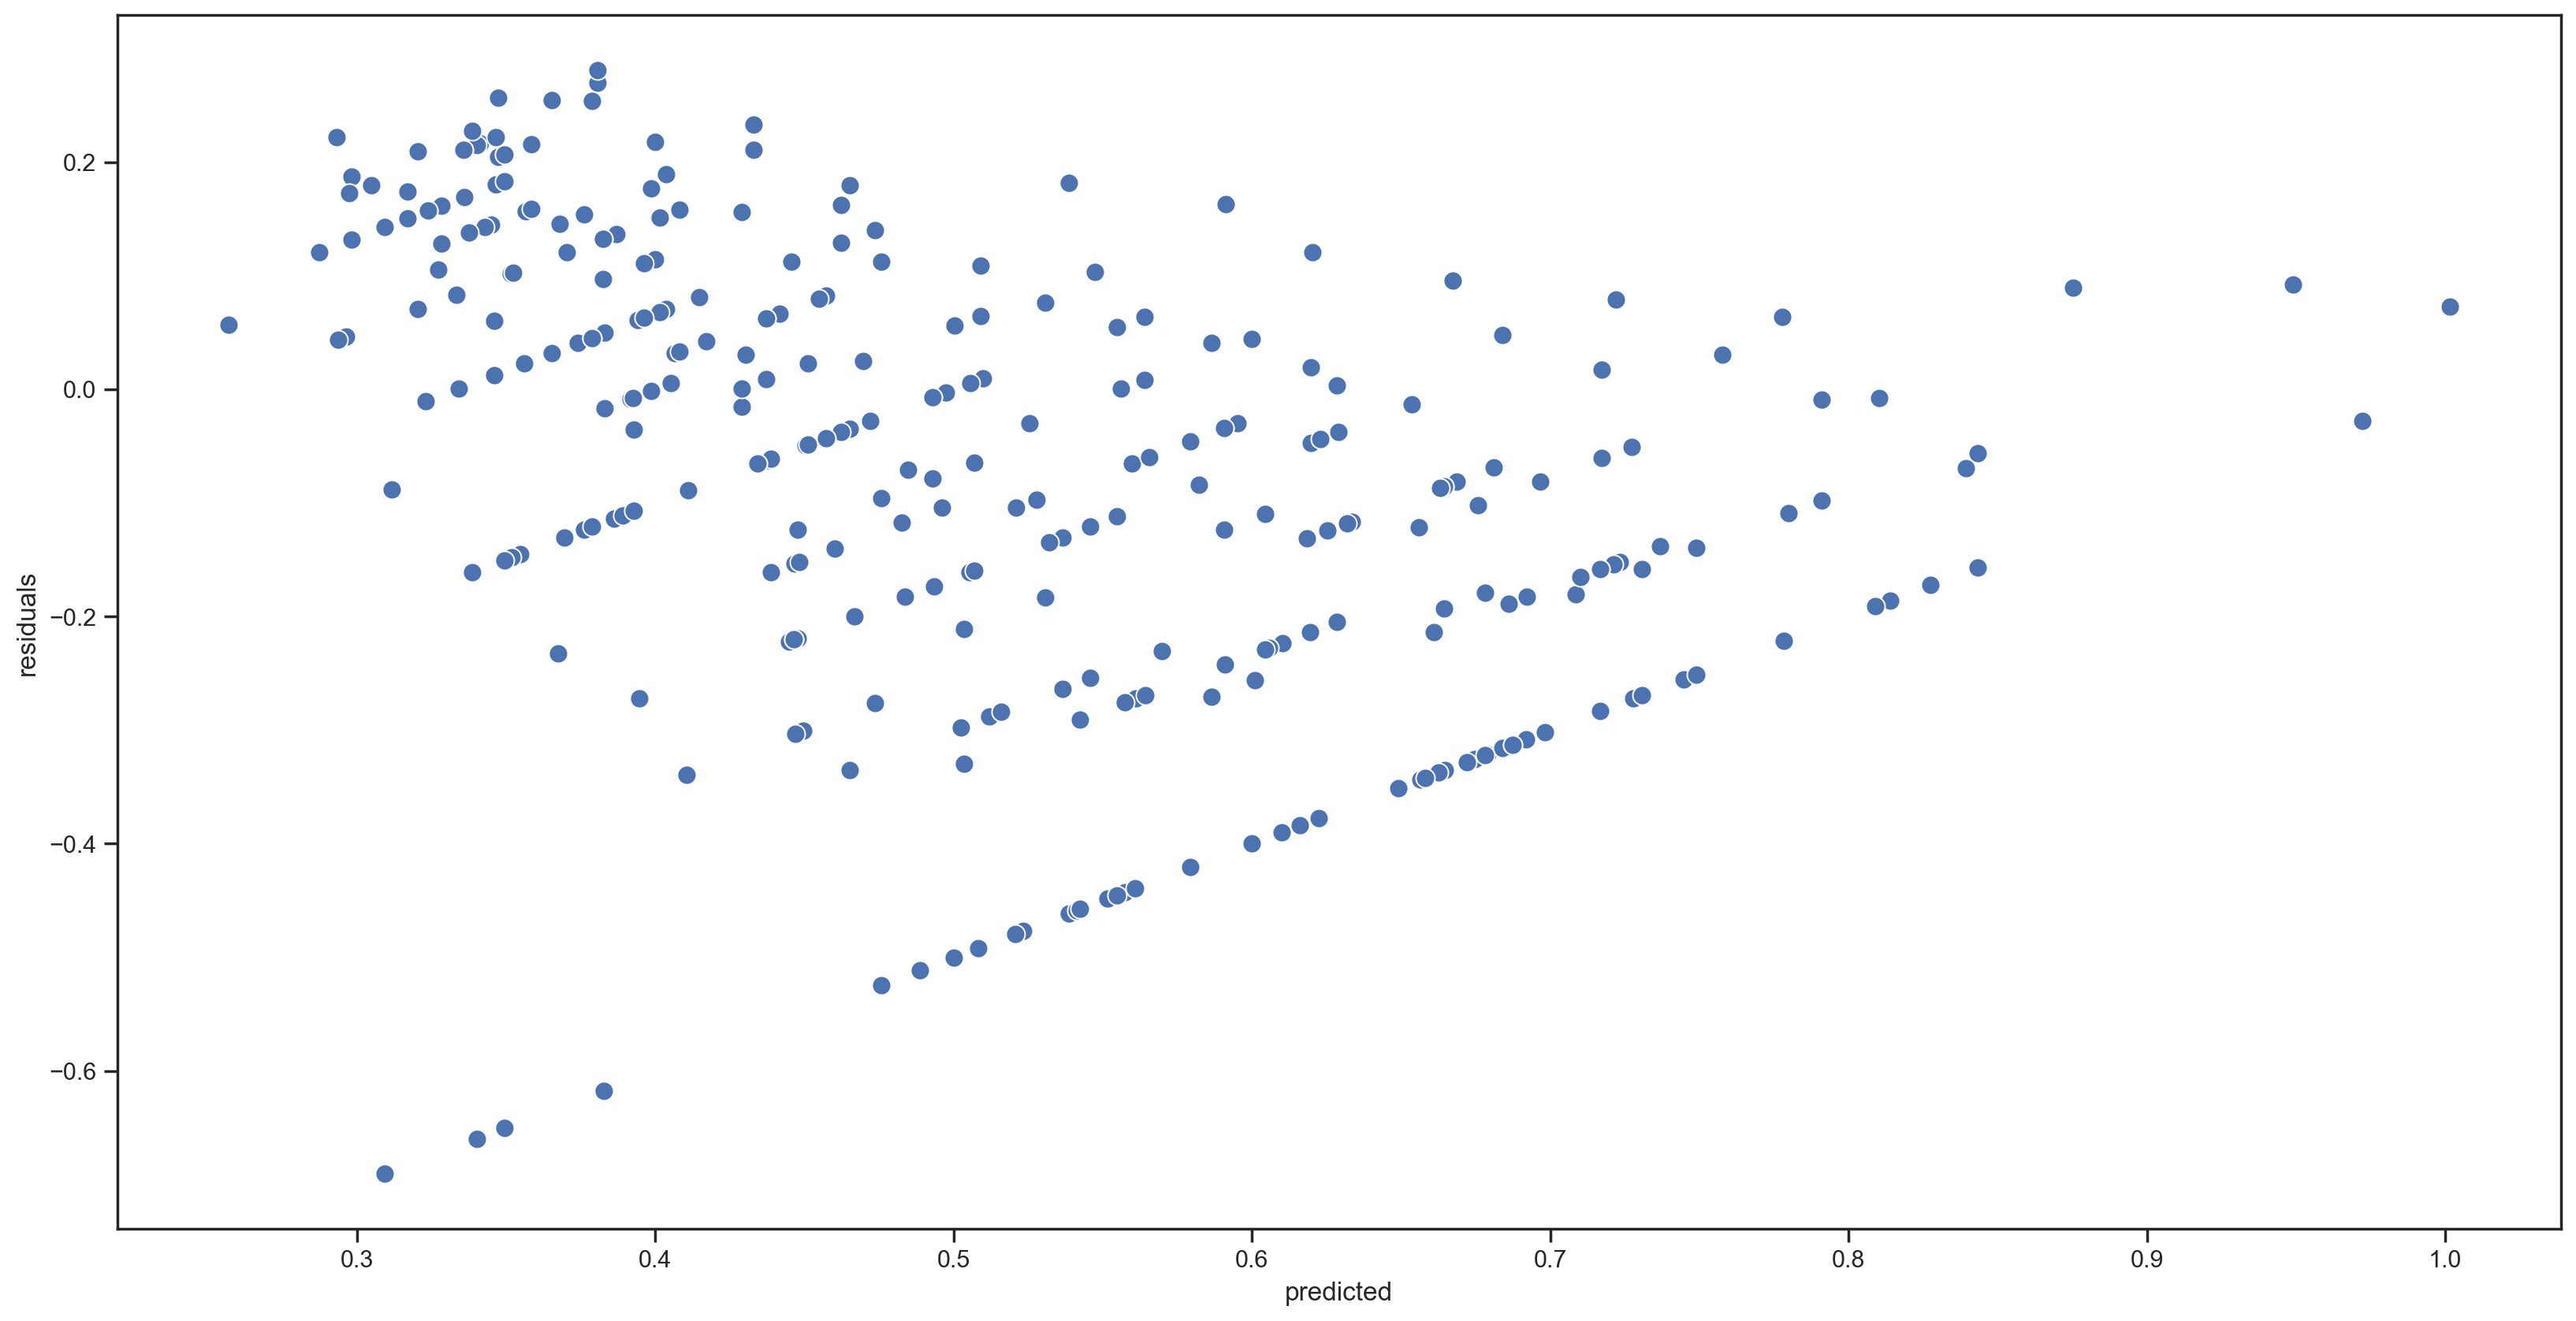

In [220]:
test_df["residuals"] = test_df["predicted"] - test_df["prob_of_release"]
sns.scatterplot(data=test_df, x="predicted", y="residuals", s=75)

In [221]:
list(zip(reg.feature_names_in_, reg.coef_))

[('days_since_previous_release', 0.05861345522721073),
 ('month_holidays', 0.00918701708813356),
 ('WD_Friday', -0.005659371006507956),
 ('WD_Monday', -0.024132531888044147),
 ('WD_Saturday', -0.017480303003139897),
 ('WD_Sunday', -0.021250837024081516),
 ('WD_Thursday', 0.023753630479174163),
 ('WD_Tuesday', 0.014838015867131928),
 ('WD_Wednesday', 0.02993139654336181),
 ('M_Apr', 0.027833671472110206),
 ('M_Aug', -0.020604692221163227),
 ('M_Dec', -0.017070429139239736),
 ('M_Feb', -0.039875851182106674),
 ('M_Jan', -0.0024317125895619305),
 ('M_Jul', 0.022885429021561664),
 ('M_Jun', 0.009577795171212478),
 ('M_Mar', -0.048495849701349764),
 ('M_May', -0.00539008881920426),
 ('M_Nov', 0.013919223375007051),
 ('M_Oct', 0.018432078394413486),
 ('M_Sep', 0.041220426227596516)]

In [222]:
test_df[["prob_of_release", "predicted", "residuals"]].sort_values(by=["residuals"])

,prob_of_release,predicted,residuals
2112,1.000000,0.309301,-0.690699
1965,1.000000,0.340070,-0.659930
2091,1.000000,0.349477,-0.650523
1931,1.000000,0.382741,-0.617259
2028,1.000000,0.475631,-0.524369
...,...,...,...
2097,0.125000,0.378890,0.253890
1950,0.111111,0.365362,0.254251
1900,0.090909,0.347385,0.256476
1865,0.111111,0.380609,0.269497
